In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras import losses

from tensorflow.keras.metrics import AUC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, matthews_corrcoef, roc_curve, auc, roc_auc_score


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_data= pd.read_csv('/content/drive/MyDrive/ColabData/twitter_2021_altın_mudahale/preprocessed_twitter_2021_altın_mudahale.csv')

In [4]:
train_data.head()

,Unnamed: 0,tweet,Subjectivity,Polarity,Analysis
0,0,"50,000 finnish industrial workers threaten str...",0.000000,0.000000,Neutral
1,1,happened btc$100k eoy 🤷‍♂️ reminds fools gold ...,0.000000,0.000000,Neutral
2,2,plop supercooled ice 💦 copper gold swimmingspo...,0.400000,-0.150000,Negative
3,3,jp morgan turns bearish anything-- especially ...,1.000000,0.000000,Neutral
4,4,2021 year clean energy finally faced mining pr...,0.679451,0.157656,Positive


In [5]:
# calculate word count of each sentence
train_data['word_counter'] = train_data['tweet'].apply(lambda x:len(str(x).split())) 

In [6]:
print('Info about training data:')
print(train_data['Analysis'].value_counts())
print('Total comments: ', len(train_data))

# will be used in cnn
max_train_sentence_length  = train_data['word_counter'].max()

Info about training data:
Neutral     4992
Positive    3088
Negative     848
Name: Analysis, dtype: int64
Total comments:  8928


In [7]:
# will be used for padding
print('Train Max Sentence Length :'+str(max_train_sentence_length))

Train Max Sentence Length :48


In [8]:
# consider 30k comments
num_words = 30000

# convert texts to number format - for tensorflow.

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['tweet'].values.astype(str).tolist())

print(str(tokenizer.texts_to_sequences(['this is a test'])))

[[1625, 3678, 1000, 1006]]


In [9]:
# splitting train and test data
X_train, X_test, y_train, y_test = train_test_split(train_data['tweet'],\
                                                      train_data['Analysis'],\
                                                      test_size=0.1,\
                                                      random_state=0)

In [10]:
# text-to-number
x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )

<ipython-input-10-52717cdf9361>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train.values.astype(str)) )
<ipython-input-10-52717cdf9361>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test  = np.array( tokenizer.texts_to_sequences(X_test.values.astype(str)) )


In [11]:
# we get different length sentences after tokenizer.
# we need fixed size vectors. so padding is applied.
# max length of a sentence was given above. it was 3263.
# here we are taking maxlen=256 and applying padding (256 selected for computational cost)
x_train = pad_sequences(x_train, padding='post', maxlen=256)
x_test = pad_sequences(x_test, padding='post', maxlen=256)

In [12]:
x_train.shape

(8035, 256)

In [13]:
# label encoding: 'positive', 'negative' and 'neutral' is converted to number format.
le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))

test_labels = le.transform(y_test)
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)

['Negative', 'Neutral', 'Positive']

In [14]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [15]:
# Details for label encoding process
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

3925     Neutral
6488     Neutral
1656    Positive
842      Neutral
8159     Neutral
2104    Negative
509     Positive
8412     Neutral
5711    Positive
3435     Neutral
Name: Analysis, dtype: object
Text to number
[1 1 2 1 1 0 2 1 2 1]
Number to category
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [16]:
# Creating CNN Model

# looking for top 30k comments
max_features = 30000

#every index is represented by 64 dimensional vector
embedding_dim =64

#each input has 256 dimension
sequence_length = 256

model = tf.keras.Sequential()

# first layer is embedding layer.
model.add(tf.keras.layers.Embedding(max_features, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))     

# second is conv. layer.
# 1-dimensional for texts (2D for images)
# kernel_size = 3, looking for 3 words at a time (total of 256).
model.add(tf.keras.layers.Conv1D(128, 3, activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005))) 

# adding maxpooling after convolution layer.
# feature map is reduced by half after max pooling.
model.add(tf.keras.layers.GlobalMaxPooling1D())

# final layer, fully connected dense layer.
# 3 neurons for the output: possitive, negative and neutral.
# regularizers prevent overfitting.
model.add(tf.keras.layers.Dense(3, activation='softmax',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
                    
model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='Nadam', metrics=["CategoricalAccuracy",  AUC(name='auc')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 64)           1920000   
                                                                 
 conv1d (Conv1D)             (None, 254, 128)          24704     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 1,945,091
Trainable params: 1,945,091
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Training model
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs=10,
                    validation_data=test_ds.batch(128),
                    verbose=1)

Epoch 1/10


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


63/63 [==============================] - 12s 169ms/step - loss: 1.0712 - categorical_accuracy: 0.7013 - auc: 0.8795 - val_loss: 0.5364 - val_categorical_accuracy: 0.8858 - val_auc: 0.9740
Epoch 2/10
63/63 [==============================] - 10s 164ms/step - loss: 0.3292 - categorical_accuracy: 0.9515 - auc: 0.9955 - val_loss: 0.2186 - val_categorical_accuracy: 0.9866 - val_auc: 0.9994
Epoch 3/10
63/63 [==============================] - 10s 164ms/step - loss: 0.1765 - categorical_accuracy: 0.9929 - auc: 0.9999 - val_loss: 0.1612 - val_categorical_accuracy: 0.9922 - val_auc: 0.9998
Epoch 4/10
63/63 [==============================] - 11s 171ms/step - loss: 0.1377 - categorical_accuracy: 0.9974 - auc: 1.0000 - val_loss: 0.1369 - val_categorical_accuracy: 0.9944 - val_auc: 0.9998
Epoch 5/10
63/63 [==============================] - 11s 181ms/step - loss: 0.1183 - categorical_accuracy: 0.9991 - auc: 1.0000 - val_loss: 0.1225 - val_categorical_accuracy: 0.9955 - val_auc: 0.9997
Epoch 6/10
63/63

In [18]:
# Training model
epochs = 15
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(64),
                    epochs= epochs ,
                    validation_data=test_ds.batch(64),
                    verbose=1)

Epoch 1/15
126/126 [==============================] - 12s 99ms/step - loss: 0.0905 - categorical_accuracy: 0.9998 - auc: 1.0000 - val_loss: 0.1035 - val_categorical_accuracy: 0.9966 - val_auc: 0.9995
Epoch 2/15
126/126 [==============================] - 14s 114ms/step - loss: 0.0880 - categorical_accuracy: 0.9998 - auc: 1.0000 - val_loss: 0.1003 - val_categorical_accuracy: 0.9966 - val_auc: 0.9996
Epoch 3/15
126/126 [==============================] - 13s 100ms/step - loss: 0.0858 - categorical_accuracy: 0.9996 - auc: 1.0000 - val_loss: 0.0995 - val_categorical_accuracy: 0.9966 - val_auc: 0.9994
Epoch 4/15
126/126 [==============================] - 13s 99ms/step - loss: 0.0852 - categorical_accuracy: 0.9999 - auc: 1.0000 - val_loss: 0.0986 - val_categorical_accuracy: 0.9966 - val_auc: 0.9995
Epoch 5/15
126/126 [==============================] - 12s 99ms/step - loss: 0.0840 - categorical_accuracy: 0.9999 - auc: 1.0000 - val_loss: 0.0977 - val_categorical_accuracy: 0.9966 - val_auc: 0.999

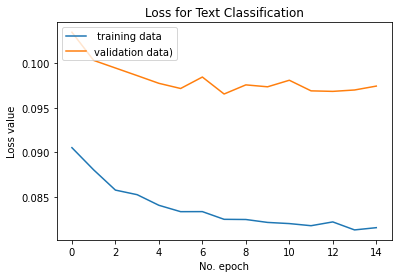

In [19]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [20]:
# Training model
epochs = 10
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(x_train,
                    train_labels,
                    epochs= epochs ,
                    validation_data=(x_test, test_labels),
                    verbose=1)

Epoch 1/10
252/252 [==============================] - 17s 67ms/step - loss: 0.0906 - categorical_accuracy: 0.9979 - auc: 0.9999 - val_loss: 0.1056 - val_categorical_accuracy: 0.9966 - val_auc: 0.9982
Epoch 2/10
252/252 [==============================] - 17s 67ms/step - loss: 0.0870 - categorical_accuracy: 0.9986 - auc: 1.0000 - val_loss: 0.1028 - val_categorical_accuracy: 0.9966 - val_auc: 0.9992
Epoch 3/10
252/252 [==============================] - 17s 66ms/step - loss: 0.0849 - categorical_accuracy: 0.9985 - auc: 1.0000 - val_loss: 0.0996 - val_categorical_accuracy: 0.9966 - val_auc: 0.9988
Epoch 4/10
252/252 [==============================] - 17s 66ms/step - loss: 0.0835 - categorical_accuracy: 0.9993 - auc: 1.0000 - val_loss: 0.1009 - val_categorical_accuracy: 0.9966 - val_auc: 0.9982
Epoch 5/10
252/252 [==============================] - 17s 67ms/step - loss: 0.0834 - categorical_accuracy: 0.9988 - auc: 1.0000 - val_loss: 0.1006 - val_categorical_accuracy: 0.9966 - val_auc: 0.9982


In [21]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'auc', 'val_loss', 'val_categorical_accuracy', 'val_auc'])


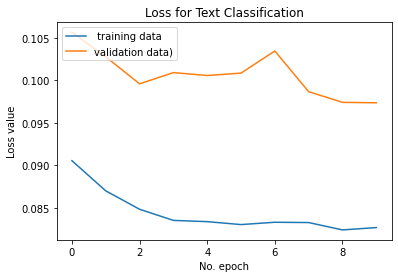

In [22]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

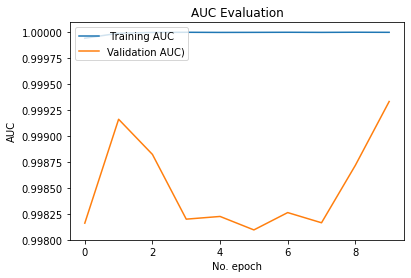

In [23]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC)')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

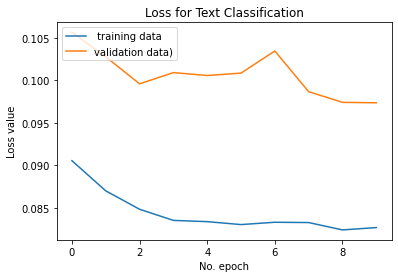

In [24]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

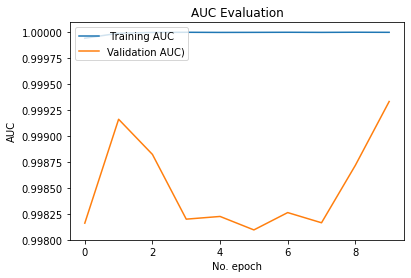

In [25]:
plt.plot(history.history['auc'], label=' Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC)')
plt.title('AUC Evaluation')
plt.ylabel('AUC')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [26]:
X_test

7624    7 reasons invest gold 👉 goldira gold smartinve...
994     expensive you, disagree ;scan barcode. hint: o...
7577    live goldprice spot gold trading $1803.3 usd, ...
6967    live goldprice spot gold trading $1816.7 usd, ...
6632    gold nosedives rs1,200 tola domestic bullion -...
                              ...                        
3994    card payment systems gwynedd | contactless por...
2076    trading signal brent : oil giving days rise. l...
1644    question? influenced? influences buy? buy want...
8009                                     الذهب xauusd adx
4860                                                cheap
Name: tweet, Length: 893, dtype: object

In [27]:
x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )
x_test2 = pad_sequences(x_test2, padding='post', maxlen=256)

<ipython-input-27-1bce84296b7e>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test2  = np.array( tokenizer.texts_to_sequences(X_test.astype(str).tolist()) )


In [28]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
y_predictions = model.predict(x_test2)
y_pred = y_predictions.argmax(axis=1)
y_pred

Generate predictions for all samples
28/28 [==============================] - 1s 16ms/step


array([1, 0, 2, 2, 1, 2, 1, 2, 1, 1, 0, 2, 1, 1, 1, 2, 2, 1, 2, 0, 2, 1,
       1, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1,
       1, 0, 1, 1, 1, 2, 2, 2, 0, 2, 2, 2, 0, 2, 1, 1, 1, 1, 1, 1, 0, 2,
       1, 2, 1, 0, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       2, 0, 1, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 0, 0, 1, 1,
       2, 1, 0, 1, 0, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 2,
       1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 2,
       1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 0, 0, 1, 1, 1,
       1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 0, 0, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 1, 1, 1, 0, 2, 2, 1, 1, 2, 2, 1, 1, 2, 0, 1, 2, 1, 1, 2,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 0, 1, 0, 2, 1, 2,
       1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 2,

In [29]:
y_test.shape
y_test

7624     Neutral
994     Negative
7577    Positive
6967    Positive
6632     Neutral
          ...   
3994     Neutral
2076    Positive
1644    Positive
8009     Neutral
4860    Positive
Name: Analysis, Length: 893, dtype: object

In [30]:
y_pred = np.where((y_pred == 0),'Negative',y_pred)
y_pred = np.where((y_pred == '1'),'Neutral',y_pred)
y_pred = np.where((y_pred == '2'),'Positive',y_pred)

In [31]:
y_pred

array(['Neutral', 'Negative', 'Positive', 'Positive', 'Neutral',
       'Positive', 'Neutral', 'Positive', 'Neutral', 'Neutral',
       'Negative', 'Positive', 'Neutral', 'Neutral', 'Neutral',
       'Positive', 'Positive', 'Neutral', 'Positive', 'Negative',
       'Positive', 'Neutral', 'Neutral', 'Positive', 'Positive',
       'Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Positive',
       'Positive', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Positive', 'Neutral', 'Positive', 'Positive', 'Neutral',
       'Neutral', 'Neutral', 'Neutral', 'Negative', 'Neutral', 'Neutral',
       'Neutral', 'Positive', 'Positive', 'Positive', 'Negative',
       'Positive', 'Positive', 'Positive', 'Negative', 'Positive',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Negative', 'Positive', 'Neutral', 'Positive', 'Neutral',
       'Negative', 'Neutral', 'Neutral', 'Positive', 'Positive',
       'Neutral', 'Positive', 'Positive', 'Neutral',

In [32]:
y_test

7624     Neutral
994     Negative
7577    Positive
6967    Positive
6632     Neutral
          ...   
3994     Neutral
2076    Positive
1644    Positive
8009     Neutral
4860    Positive
Name: Analysis, Length: 893, dtype: object

In [33]:
labels = ['Positive', 'Negative','Neutral']
print(classification_report(y_test, y_pred, labels=labels))

              precision    recall  f1-score   support

    Positive       1.00      0.99      1.00       310
    Negative       1.00      0.99      0.99        85
     Neutral       0.99      1.00      1.00       498

    accuracy                           1.00       893
   macro avg       1.00      0.99      1.00       893
weighted avg       1.00      1.00      1.00       893

